In [95]:
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd

In [96]:
HOME_DIR = '/Users/datatranslators/Documents/GitHub/acidoCEST-ML/outputs/'

## DATA

In [97]:

# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

## Split

## RF

In [98]:
cols_rf    = ['ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)', '4.4', '4.5','4.6', '4.7', '5.8', '5.9', '6']
X = acidoCEST_ML[cols_rf]
Y = acidoCEST_ML['pH']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

file = 'RF_regressor_selected.joblib'
RF_reg = load(HOME_DIR  + f'{file}' )
y_hat_RF = RF_reg.predict(X_test)

/Users/datatranslators/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/datatranslators/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


## Lasso

In [99]:
cols_lasso = ['ExpT2(ms)',
 '-1.4',
 '0.6',
 '2',
 '4.4',
 '4.5',
 '4.6',
 '4.7',
 '4.8',
 '4.9',
 '5.8',
 '5.9',
 '6']

X = acidoCEST_ML[cols_lasso]
Y = acidoCEST_ML['pH']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)


file = 'LASSO_regressor_selected.joblib'
LASSO_reg = load(HOME_DIR  + f'{file}' )
y_hat_lasso = LASSO_reg.predict(X_test)

## Comparison

In [100]:
import matplotlib.pyplot as plt
from sklearn import metrics

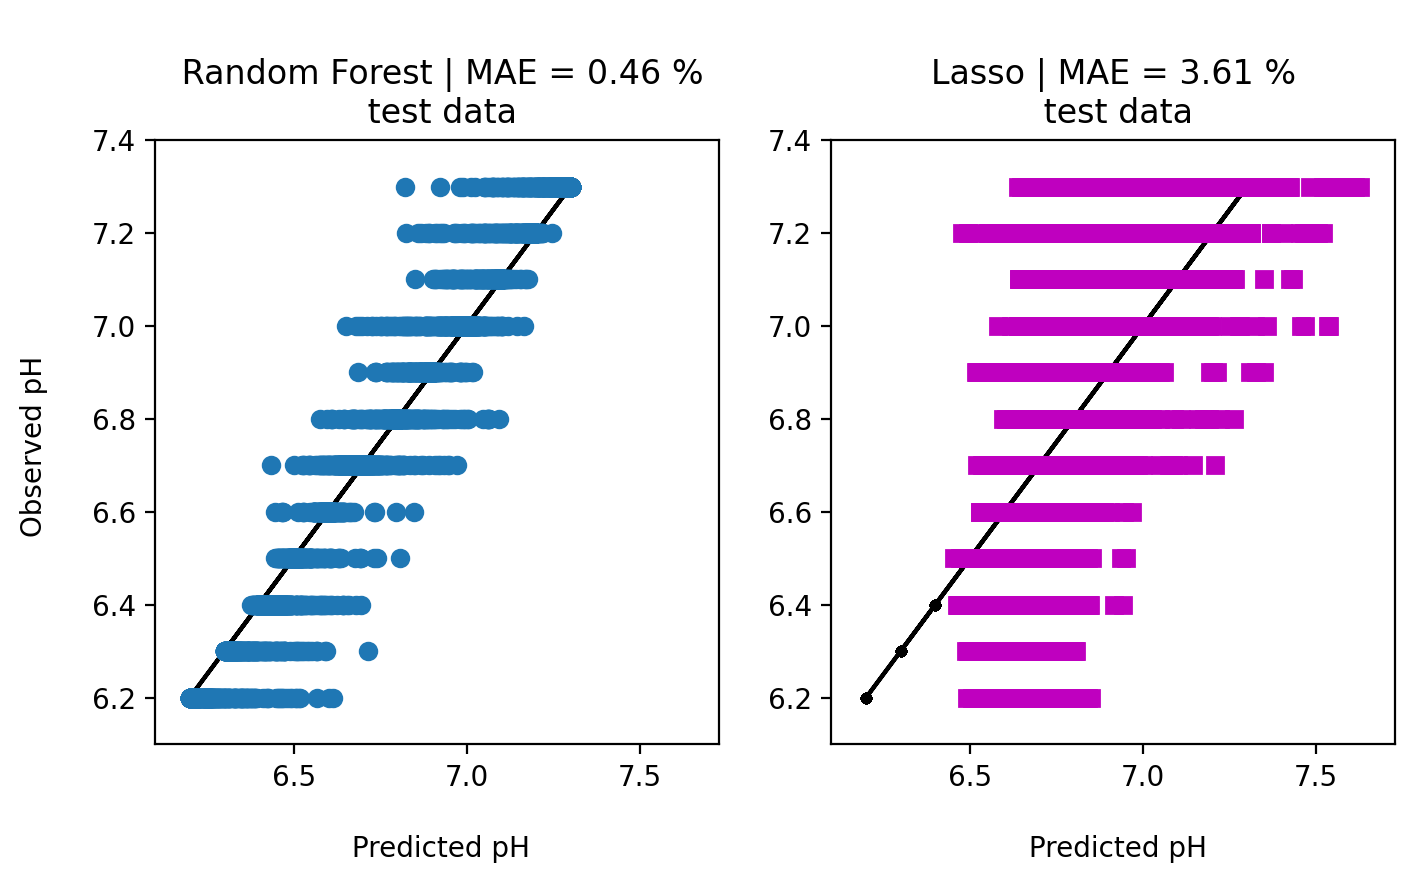

In [101]:
fig = plt.figure(dpi=200, figsize=(8,4) )
#plt.suptitle('Peformance on test set \n')

plt.subplot(1,2,1)
plt.plot(y_test,y_test,'.-k')
plt.plot(y_hat_RF,y_test,'o')
plt.xlabel('\n Predicted pH')
plt.ylabel('Observed pH \n')
plt.ylim([y_test.min()-.1, y_test.max()+.1])
plt.xlim([y_test.min()-.1, y_hat_lasso.max()+.1])

e = 100 * metrics.mean_absolute_percentage_error(y_test, y_hat_RF)
plt.title(f'\n Random Forest | MAE = {e.round(2)} %\n test data')


plt.subplot(1,2,2)
plt.plot(y_test,y_test,'.-k')
plt.plot(y_hat_lasso,y_test,'sm')
plt.xlabel('\n Predicted pH')
plt.ylim([y_test.min()-.1, y_test.max()+.1])
plt.xlim([y_test.min()-.1, y_hat_lasso.max()+.1])

e = 100 * metrics.mean_absolute_percentage_error(y_test, y_hat_lasso)
plt.title(f'Lasso | MAE = {e.round(2)} %\n test data')
plt.savefig(f'../figs/REg_comparison_test.png',bbox_inches='tight')

## Matrices of Power and Time

In [102]:
import numpy as np
import seaborn as sns

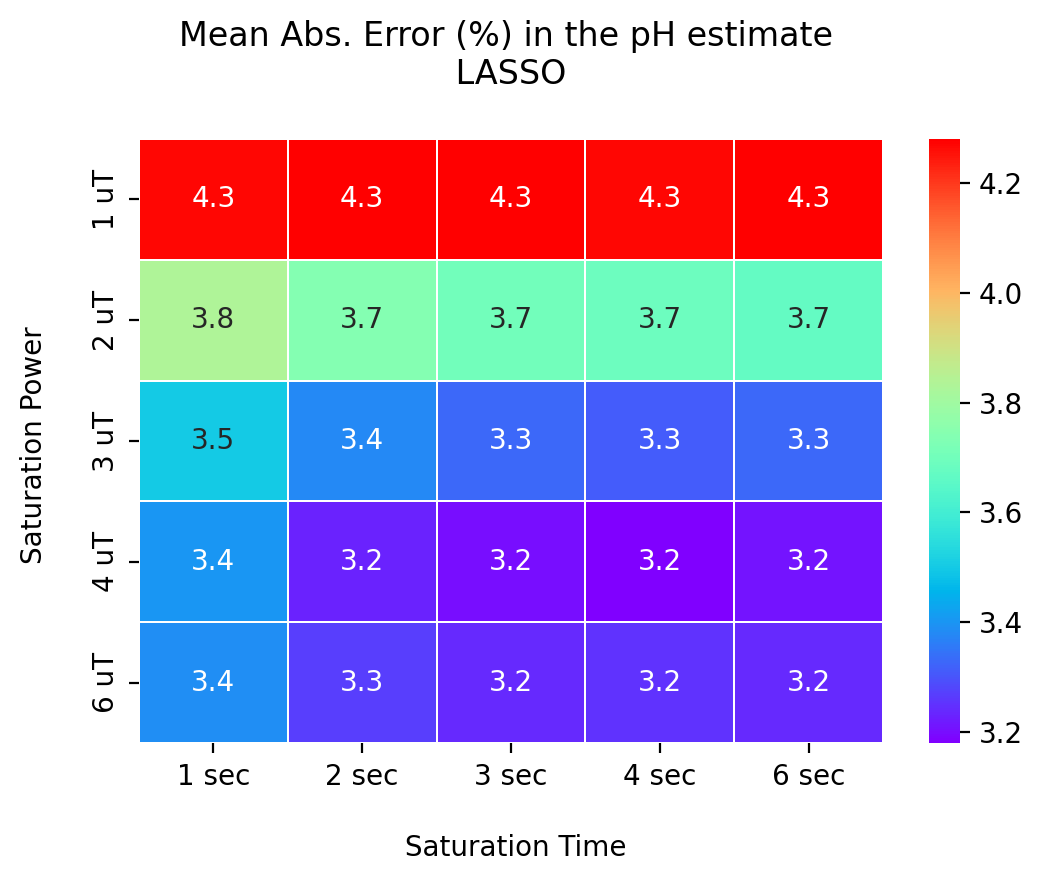

In [103]:
sat_times = acidoCEST_ML['SatTime(ms)'].unique()
#sat_times.sort()

sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
#sat_powers.sort()

M_lasso = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)

for t in sat_times:
    for p in sat_powers:
        D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]
        
        Xdata = D[cols_lasso]
        Ydata = D['pH']
        
        #_, train, test = train_lasso(Xdata,Ydata, create_fig=0)
        e = 100 * metrics.mean_absolute_percentage_error(Ydata, LASSO_reg.predict(Xdata) )
        
        M_lasso.loc[p,:][t] = e.round(2)

M_lasso.columns = [str(int(x/1000)) + ' sec'  for x in M_lasso.columns]
M_lasso.index   = [f'{int(x)} uT' for  x in M_lasso.index ]

_, ax = plt.subplots(dpi=200)

cols_ = list(M_lasso.columns)
cols_.sort()

idx = list(M_lasso.index)
idx.sort()


sns.heatmap(M_lasso.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
plt.xlabel('\n Saturation Time')
plt.ylabel('Saturation Power \n')
plt.title('Mean Abs. Error (%) in the pH estimate \n LASSO \n')

plt.savefig(f'../figs/MATRIX_regression_LASSO.png',bbox_inches='tight')

## RF

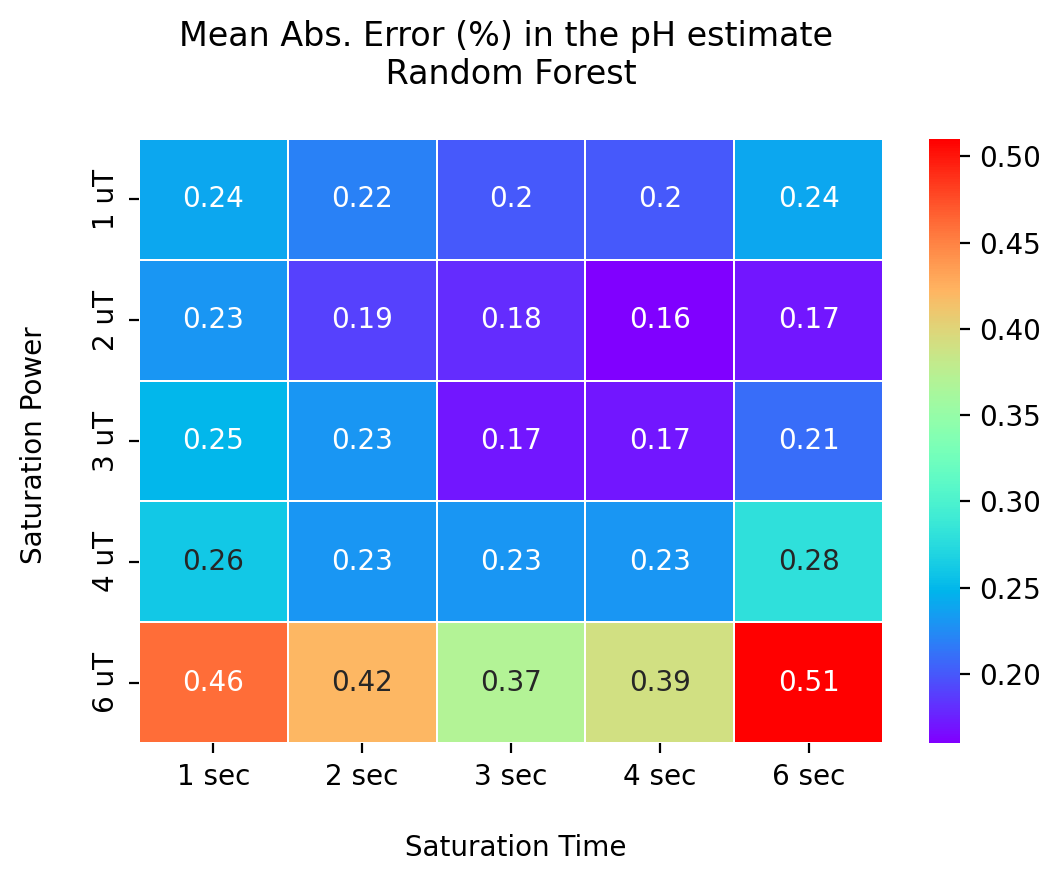

In [105]:
sat_times = acidoCEST_ML['SatTime(ms)'].unique()
#sat_times.sort()

sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
#sat_powers.sort()

M_lasso = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)

for t in sat_times:
    for p in sat_powers:
        D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]
        
        Xdata = D[cols_rf]
        Ydata = D['pH']
        
        #_, train, test = train_lasso(Xdata,Ydata, create_fig=0)
        e = 100 * metrics.mean_absolute_percentage_error(Ydata, RF_reg.predict(Xdata) )
        
        M_lasso.loc[p,:][t] = e.round(2)

M_lasso.columns = [str(int(x/1000)) + ' sec'  for x in M_lasso.columns]
M_lasso.index   = [f'{int(x)} uT' for  x in M_lasso.index ]

_, ax = plt.subplots(dpi=200)

cols_ = list(M_lasso.columns)
cols_.sort()

idx = list(M_lasso.index)
idx.sort()


sns.heatmap(M_lasso.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
plt.xlabel('\n Saturation Time')
plt.ylabel('Saturation Power \n')
plt.title('Mean Abs. Error (%) in the pH estimate \n Random Forest \n')

plt.savefig(f'../figs/MATRIX_regression_RF.png',bbox_inches='tight')